## K-means 均值聚类算法
### 加载待标注数据

In [114]:
from numpy import *

In [115]:
# 加载数据

dataArr = []
fr = open('testSet.txt')
for line in fr.readlines():
    lineArr = line.strip().split('\t')
    floatArr = [float(ele) for ele in lineArr]
    dataArr.append(floatArr)
dataMat = mat(dataArr)

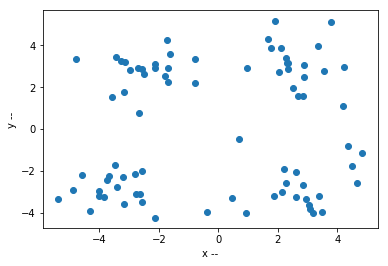

In [116]:
"""
待标注数据
"""
import matplotlib.pyplot as plt
xData = dataMat[:,0]
yData = dataMat[:,1]

plt.scatter(xData, yData)
plt.xlabel('x --')
plt.ylabel('y --')
plt.show()

In [117]:
# 绘制 k-means cluster 数据
def plotKmeans(dataSet, assignMat, centroids, title):
    plt.title(title)
    colors = ['c','r','g','b']
    k = shape(centroids)[0]
    for i in range(k):
        clusterI = dataSet[nonzero(assignMat[:,0].A == i)[0]]
        plt.scatter(clusterI[:, 0], clusterI[:, 1], c=colors[i])
        plt.scatter(centroids[i,0], centroids[i,1], marker='x', s=40, c='k')
    plt.show()

In [118]:
'''
K-means 算法
'''
from numpy import *

'''
K-means 支持函数
'''
# 欧式距离计算
def calcEclud(vecA, vecB):
    return sqrt(sum(power(vecA - vecB, 2)))

# 随机获取 k 个聚类点
def randCentroids(dataSet, k):
    n = shape(dataSet)[1]
    centroids = mat(zeros((k, n)))
    for i in range(n):
        minValue = min(dataSet[:, i])
        maxValue = max(dataSet[:, i])
        rangeValue = float(maxValue - minValue)
        centroids[:, i] = minValue + rangeValue * random.rand(k, 1)
    return centroids

# kMeans 算法
def kMeans(dataSet, k, calcMeans = calcEclud, createCentroids = randCentroids):
    m, n = shape(dataSet)
    assignMat = mat(zeros((m, 2)))
    centroids = createCentroids(dataSet, k)
    changed = True
    times = 0
    while changed:
        if times == 0:
            title = 'Origin Data'
        else:
            title = str(times) + 'th k-menas cluster'
        times += 1
        plotKmeans(dataSet, assignMat, centroids, title)
        changed = False
        for i in range(m):
            # 根据最小距离对样本进行分类
            minDist = inf # inf 是 numpy 中定义的无穷大.
            kLabel = -1
            for j in range(k):
                dist = calcMeans(dataSet[i,:], centroids[j,:])
                if dist < minDist:
                    minDist = dist
                    kLabel = j
            if kLabel != assignMat[i, 0]:
                changed = True
            assignMat[i,:] = kLabel, minDist ** 2
        # 更新 centroids 的新的位置。
        for j in range(k):
            kClusterPoints = dataSet[nonzero(assignMat[:,0] ==j)[0]]
            centroids[j] = mean(kClusterPoints, axis = 0)
    plotKmeans(dataSet, assignMat, centroids, 'Final k-means cluster')
    return centroids, assignMat       

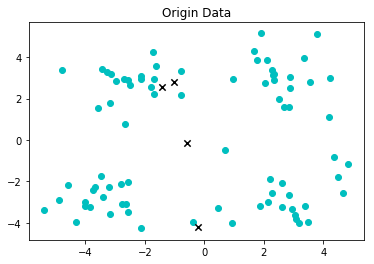

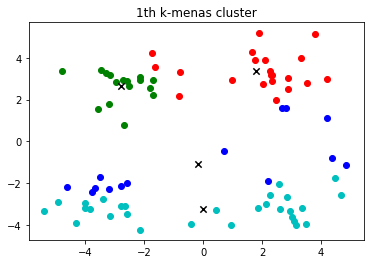

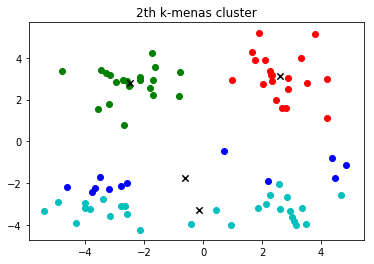

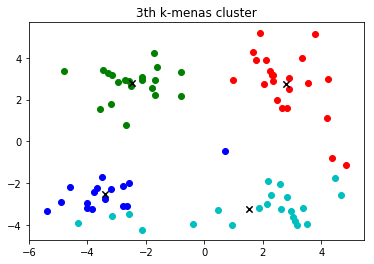

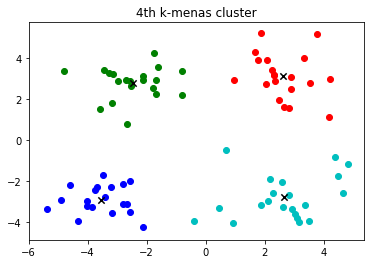

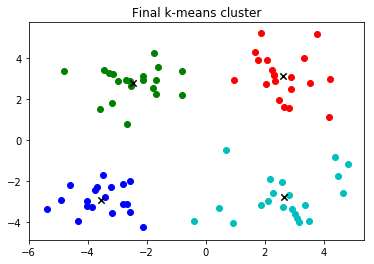

In [119]:
ctds, assignMat = kMeans(dataMat, 4)